### Case Study number of blogposts

In [27]:
import os
if not os.path.isfile('blogdata/BlogFeedback.zip'):
    !mkdir blogdata
    print("Installing wget")
    !pip install wget
    import wget
    print("Downloading file")
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip', 'blogdata/BlogFeedback.zip')
    print("Unzipping content")
    !unzip blogdata/BlogFeedback.zip -d blogdata
else:
    print("File exists")

File exists


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev
TF  Version 2.0.0-alpha0


In [60]:
# Loading to the data
d = np.loadtxt("blogdata/blogData_train.csv", delimiter=',', dtype=np.float32)
Xu = d[:,0:279]
y = d[:,280]
d.shape, Xu.shape, y.shape

((52397, 281), (52397, 279), (52397,))

In [62]:
Xmean = np.mean(Xu,axis=0)
Xsd = np.std(Xu,axis=0)
X = (Xu-Xmean)/(Xsd+1e-10)

In [63]:
## Definition of the custom parametrized distribution
def my_poiss(t):
    return tfd.Poisson(rate=t) #Equivalent to log_rate=t when using linear activation 

In [160]:
## Definition of the model
#Using the functional API for clarity
inputs = tf.keras.layers.Input(shape=(279,))
rate = tf.keras.layers.Dense(1000, activation='sigmoid')(inputs)
rate = tf.keras.layers.Dense(100, activation='sigmoid')(inputs)
rate = tf.keras.layers.Dense(100, activation='sigmoid')(inputs)
rate = tf.keras.layers.Dense(1, 
                             activation=tf.exp, 
                             bias_initializer='zeros', 
                             kernel_initializer='zeros')(rate)
p_y = tfp.layers.DistributionLambda(my_poiss)(rate) #<------- Here we hand-in the the custom distribution

#Glueing input and output together. Note that output is a tf.distirbution 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)

In [161]:
def negloglik(y_true, y_hat):
  return -y_hat.log_prob(y_true)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

In [162]:
hist = model.fit(X, y, epochs=30, verbose=True, validation_split=0.1);

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 2s 41us/sample - loss: 9.2042 - val_loss: 3.8120
Epoch 2/30
47157/47157 [==============================] - 2s 39us/sample - loss: 7.7384 - val_loss: 3.7715
Epoch 3/30
47157/47157 [==============================] - 2s 38us/sample - loss: 7.4375 - val_loss: 4.8550
Epoch 4/30
47157/47157 [==============================] - 2s 40us/sample - loss: 7.0045 - val_loss: 3.8313
Epoch 5/30
47157/47157 [==============================] - 2s 39us/sample - loss: 6.7611 - val_loss: 4.2046
Epoch 6/30
47157/47157 [==============================] - 2s 39us/sample - loss: 6.6786 - val_loss: 3.6040
Epoch 7/30
47157/47157 [==============================] - 2s 39us/sample - loss: 6.4796 - val_loss: 3.5932
Epoch 8/30
47157/47157 [==============================] - 2s 39us/sample - loss: 6.2094 - val_loss: 3.5470
Epoch 9/30
47157/47157 [==============================] - 2s 39us/sample - loss: 5.9084 - val_l

5.828936302719364

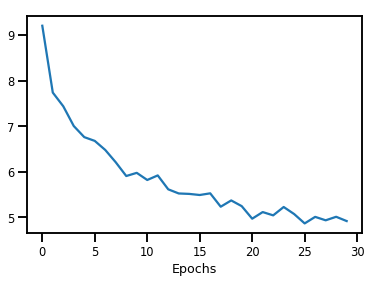

In [163]:
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
np.mean(hist.history['loss'])

In [164]:
d = np.loadtxt("blogdata/blogData_test-2012.03.22.00_00.csv", delimiter=',', dtype=np.float32)
Xtu = d[:,0:279]
yt = d[:,280]
Xt = (Xtu-Xmean) / (Xsd+1e-10)
d.shape, Xtu.shape, yt.shape

((206, 281), (206, 279), (206,))

In [165]:
#Glueing input and output together. Note that output is a tf.distirbution 
model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean())

In [166]:
y_pred = model_mean.predict(Xt).flatten()

In [167]:
y_pred.shape

(206,)

In [168]:
np.mean((y_pred - yt)**2)

422.72278

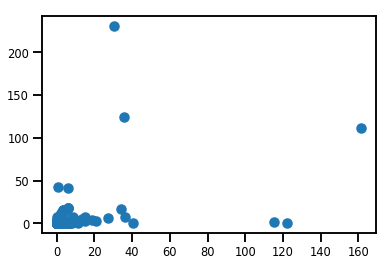

In [169]:
plt.scatter(y_pred, yt)

In [170]:
files = [f for f in os.listdir('blogdata/') if f.startswith('blogData_test')]
hits_at10 = np.zeros(len(files))
for i,f in enumerate(files):
    d = np.loadtxt("blogdata/"+f, delimiter=',', dtype=np.float32)
    #print("{}".format(i))
    Xtu = d[:,0:279]
    yt = d[:,280]
    Xt = (Xtu-Xmean) / (Xsd+1e-10)
    d.shape, Xtu.shape, yt.shape
    y_pred = model_mean.predict(Xt).flatten()
    idx_true = np.argsort(yt)[-10:]
    idx_pred = np.argsort(y_pred)[-10:] #The 10 higest
    hits_at10[i]=len(np.intersect1d(idx_true, idx_pred))

In [171]:
np.mean(hits_at10), np.std(hits_at10)/np.sqrt(len(files))

(4.966666666666667, 0.14900907255500823)